<a href="https://colab.research.google.com/github/jdmedinatobon/proyectoMachineLearning/blob/master/EntrenamientoModelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip3 install xgboost

In [0]:
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import time

from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt

import tensorflow.keras as keras
from keras import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.regularizers import l2

In [0]:
#pathDatos = "drive/My Drive/datosDescriptoresPruebaV3.txt"
pathDatos = "datosDescriptoresPruebaV3.txt"
separador = ";"

def importarDatos(pArchivo):

  datos = []

  archivo = open(pArchivo, "r")
  lineas = archivo.readlines()
  for linea in lineas:
    linea = linea.replace('\n','')
    muestra = linea.split(separador)
    muestra=np.array(muestra)

    datos.append(muestra.astype(float))
  datos=np.array(datos)
  datosx=datos[:,0:datos[0].shape[0]-2]
  datosy=datos[:,datos[0].shape[0]-1]
  datosy=datosy.astype(int)
  return datosx,datosy
    
def pruebaBinaria(pEtiquetas):
  etiquetasBinarias = np.zeros(len(pEtiquetas))

  for i in range(0,len(pEtiquetas)):
    if(pEtiquetas[i] == 2):
      etiquetasBinarias[i] = 1

  return etiquetasBinarias

In [85]:
datos_x, datos_y = importarDatos(pathDatos)

datos_y_binarios = pruebaBinaria(datos_y)

array([0., 0., 1., ..., 0., 1., 1.])

# Preprocesamiento

In [0]:
#Funcion para normalizar los datos.
#pDatos_Para_Normalizar: Son los datos con respecto a los cuales se normaliza.
#pDatos: Son los datos a normalizar.
def normalizar(pDatos_Para_Normalizar, pDatos):
 #Se inicializa el preprocesamiento de los datos
  normalizar = preprocessing.Normalizer().fit(pDatos_Para_Normalizar) #se obtiene una funcion que permita a 
  #partir de la media y los valores maximos y minimos de los datos de entrenamiento de este modelo, normalizar los datos de prueba y de entrenamiento
  dato_normal = normalizar.transform(pDatos) #Datos normailzados y con los cuales se entrenarán los modelos 
  return dato_normal

#Funcion que calcula las componentes principales de x.
#pNumComponentes: Es el numero de componentes principales que se van a calcular. Enviar -1 si se quiere calcular todas.
def darComponentesPrincipales(x, pNumComponentes):

    if(pNumComponentes != -1):
      pca = PCA(n_components = pNumComponentes)
    else:
      pca = PCA()
      
    pca.fit(x)
    return pca

#Funcion que retorna las componentes utilizadas para blanquear los datos.
def darBlanqueamiento(x):
    pca = PCA(whiten = True)
    pca.fit(x)
    return pca


In [0]:
#Normalizar los datos
datos_x_norm=normalizar(datos_x,datos_x)

#Calcular los datos con el 99% de la varianza explicada en las componentes principales
pca = darComponentesPrincipales(datos_x,1)
datos_x_pca = pca.transform(datos_x)

#Blanquear los datos
blan = darBlanqueamiento(datos_x)
datos_x_blan = blan.transform(datos_x)

X_train, X_test, y_train, y_test = train_test_split(datos_x_blan, datos_y_binarios, random_state = 0, test_size=0.10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


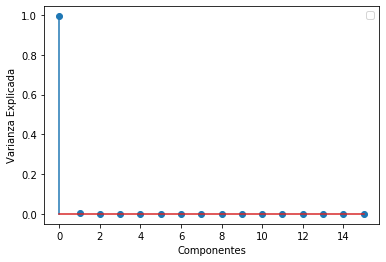

[9.94067934e-01 5.81216613e-03 1.16287703e-04 3.60314856e-06
 4.31372811e-09 3.55194064e-09 1.06854382e-09 3.50782015e-11
 9.01059961e-12 2.72415959e-12 3.29013989e-13 1.16731195e-13
 2.91716009e-14 1.40728851e-14 2.24243879e-19 8.60678167e-30]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


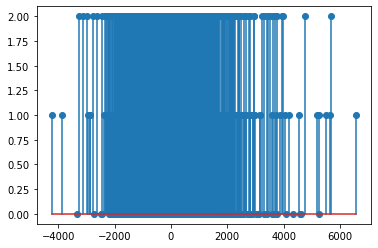

In [71]:
#Grafica las componentes principales de los datos_x e indica el numero de componentes que suman el 97% de la varianza total.
pca = darComponentesPrincipales(datos_x,-1)

plt.stem(pca.explained_variance_ratio_)
plt.xlabel("Componentes")
plt.ylabel("Varianza Explicada")
plt.legend()
plt.show()

print(pca.explained_variance_ratio_)

#Grafica los datos_x con una sola componente principal indicando la clase a la que pertenece
pca = darComponentesPrincipales(datos_x,1)
numDatos = 100
plt.stem(pca.transform(datos_x), datos_y)
plt.show()

In [46]:
n=10
error=[]
Proba_error_prueba=100000
error_actual=1000000
Proba_error_prueba_tan=100000
modeloPrueba = MLPClassifier(activation = 'relu',hidden_layer_sizes=(n,2), max_iter=1, batch_size=2, solver='adam', tol=0.001, warm_start =True,momentum=0.6, learning_rate_init=0.001, learning_rate = 'adaptive', nesterovs_momentum=True, power_t=0.5)#0.6
for i in range(0,150):
    modeloPrueba.fit(X_train,y_train)
    error_actual = 1-modeloPrueba.score(X_test,y_test)
    error.append(error_actual)
    if(error_actual<Proba_error_prueba):
        N_neuronas=n
        fcn_activacion="tanh"
        modelo = modeloPrueba
        Proba_error_prueba = error_actual
    if(error_actual<Proba_error_prueba_tan):
        N_neuronas_tan=n
        modelo_tan = modeloPrueba
        Proba_error_prueba_tan = error_actual
print("Número de neuronas utilizadas para la mejor probabilidad de error para tanh descenso de gradiente")
print(N_neuronas_tan)
print("Mejor probabilidad de acierto para función de activación tanh con descenso de gradiente")
print(1-Proba_error_prueba_tan)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Número de neuronas utilizadas para la mejor probabilidad de error para tanh descenso de gradiente
10
Mejor probabilidad de acierto para función de activación tanh con descenso de gradiente
0.3416666666666667


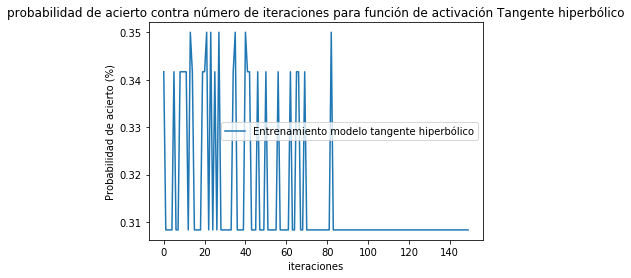

In [44]:
plt.plot((1-np.array(error)), label = "Entrenamiento modelo tangente hiperbólico") 
plt.xlabel('iteraciones') 
plt.ylabel('Probabilidad de acierto (%)') 
plt.title('probabilidad de acierto contra número de iteraciones para función de activación Tangente hiperbólico') 
plt.legend() 
plt.show()

In [41]:
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 

# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions)
print(np.sum(np.diag(cm))/360)
print(cm)

0.31666666666666665
[[  4   0 122]
 [  3   2 118]
 [  3   0 108]]


#Implementación con Keras

In [92]:
def graficarHistoriaAccuracy(pHist):
  plt.plot(pHist.history['sparse_categorical_accuracy'], label = 'Accuracy')
  plt.xlabel('Epoca')
  plt.ylabel('Accuracy Entrenamiento')
  plt.title("Accuracy de Entrenamiento vs Epoca")
  plt.legend()
  plt.show()

def graficarHistoriaValAccuracy(pHist):
  plt.plot(hist.history['val_sparse_categorical_accuracy'], label = 'Accuracy Validacion')
  plt.xlabel('Epoca')
  plt.ylabel('Accuracy Validacion')
  plt.title("Accuracy de Validacion vs Epoca")
  plt.legend()
  plt.show()

tasa = 0.001
alpha = 0.01

modelo = Sequential()
modelo.add(Dense(16, use_bias = True, kernel_initializer='random_uniform', input_dim = 16, activation = "sigmoid",activity_regularizer=l2(alpha)))
modelo.add(Dense(8, use_bias = True, activation = "relu"))
modelo.add(Dense(2, activation = "softmax"))

sgd = optimizers.SGD(lr = tasa)

modelo.compile(loss='sparse_categorical_crossentropy', optimizer = sgd, metrics = ['sparse_categorical_accuracy'])
hist = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 100, batch_size = 1800)

Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 1s 754us/step - loss: 65.4152 - sparse_categorical_accuracy: 0.6654 - val_loss: 7.7766 - val_sparse_categorical_accuracy: 0.6778
Epoch 2/100
1620/1620 [==============================] - 0s 6us/step - loss: 64.9012 - sparse_categorical_accuracy: 0.6654 - val_loss: 7.7205 - val_sparse_categorical_accuracy: 0.6778
Epoch 3/100
1620/1620 [==============================] - 0s 5us/step - loss: 64.3913 - sparse_categorical_accuracy: 0.6654 - val_loss: 7.6649 - val_sparse_categorical_accuracy: 0.6778
Epoch 4/100
1620/1620 [==============================] - 0s 4us/step - loss: 63.8854 - sparse_categorical_accuracy: 0.6654 - val_loss: 7.6097 - val_sparse_categorical_accuracy: 0.6778
Epoch 5/100
1620/1620 [==============================] - 0s 3us/step - loss: 63.3836 - sparse_categorical_accuracy: 0.6654 - val_loss: 7.5550 - val_sparse_categorical_accuracy: 0.6778
Epoch 6/100
1620/1620 [========

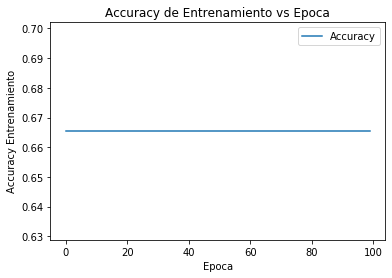

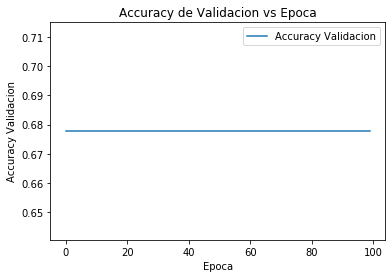

In [94]:
graficarHistoriaAccuracy(hist)
graficarHistoriaValAccuracy(hist)

In [93]:
test = modelo.predict(datos_x_blan)
test[0:50,:]

array([[0.59737176, 0.4026282 ],
       [0.5976125 , 0.40238744],
       [0.5901384 , 0.40986168],
       [0.588655  , 0.41134498],
       [0.59023446, 0.4097655 ],
       [0.5977707 , 0.40222928],
       [0.5874153 , 0.41258472],
       [0.59335154, 0.4066485 ],
       [0.58992577, 0.41007423],
       [0.59132147, 0.4086786 ],
       [0.60221136, 0.39778858],
       [0.5933601 , 0.40663987],
       [0.5881667 , 0.41183332],
       [0.58639866, 0.41360134],
       [0.5932587 , 0.40674135],
       [0.59035987, 0.40964016],
       [0.5933212 , 0.40667877],
       [0.5941713 , 0.40582868],
       [0.58985025, 0.41014972],
       [0.59549314, 0.4045068 ],
       [0.5947673 , 0.40523276],
       [0.59511876, 0.4048812 ],
       [0.5852383 , 0.4147617 ],
       [0.5982741 , 0.40172586],
       [0.5991279 , 0.4008721 ],
       [0.6008706 , 0.3991294 ],
       [0.5953157 , 0.40468433],
       [0.5941522 , 0.40584776],
       [0.59535766, 0.4046423 ],
       [0.59977955, 0.40022045],
       [0.

In [34]:
test[0]

array([0.23551697, 0.28870574, 0.47577727], dtype=float32)

In [96]:
2**12

4096